# Feature Engineering Notebook

## Introduction

In this notebook, we will focus on some **Feature Engineering**, an essential step in preparing our dataset for model training. The goal of feature engineering is to enhance the predictive power of our data by transforming it into a format that captures the most important information and relationships.

### Project Goal

The goal of this project is to build a machine learning model that can identify stocks that **outperform the S&P 500 by more than 2%**. By selecting high-performing stocks, we aim to create a portfolio capable of beating the market.

### Key Tasks in Feature Engineering

1. **Principal Component Analysis (PCA)**:
   - We will use PCA to reduce the dimensionality of the dataset. This technique helps in summarizing the most important features and eliminates redundancy by addressing multicollinearity. PCA will ensure that we retain only the most valuable information, which will improve model performance and efficiency.

2. **Clustering**:
   - Clustering will be applied to group stocks based on their similarities. This can help us uncover hidden patterns in the data and create additional features that represent stock groupings. These clusters can provide insights into different stock behaviors and trends.

3. **Target Variable Engineering**:
   - We will create a new target variable that identifies stocks that outperform the S&P 500 by more than 2%. This target will help guide the machine learning model to focus on the stocks that have the highest potential for significant returns.

4. **Next Steps**:
   
Through these steps, we aim to refine our dataset and ensure it is optimized for building a robust machine learning model capable of selecting a portfolio of stocks that outperforms the market.


### Importing Libraries

In [18]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import yfinance as yf

import os

### Load Datasets

In [2]:
# Load all datasets from 2014 to 2018
data_2014 = pd.read_csv('data/outliers_data/2014_15_Capped_outliers.csv')
data_2015 = pd.read_csv('data/outliers_data/2015_15_Capped_outliers.csv')
data_2016 = pd.read_csv('data/outliers_data/2016_15_Capped_outliers.csv')
data_2017 = pd.read_csv('data/outliers_data/2017_15_Capped_outliers.csv')
data_2018 = pd.read_csv('data/outliers_data/2018_15_Capped_outliers.csv')
# Data 2018 is already loaded as data_2018

full_df = {'2014': data_2014,
           '2015': data_2015,
           '2016': data_2016,
           '2017': data_2017,
           '2018': data_2018
          }

# Print the head of each year
for year, df in full_df.items():
    print(f"Head of {year}:")
    print(df.head(), "\n")

Head of 2014:
  Symbol       Revenue  Revenue Growth  Cost of Revenue  Gross Profit  \
0     PG  1.664037e+10       -0.071300     8.829338e+09  6.055261e+09   
1   VIPS  3.734148e+09        1.148175     2.805625e+09  9.285226e+08   
2     KR  1.664037e+10        0.018200     8.829338e+09  6.055261e+09   
3    RAD  1.664037e+10        0.005300     8.829338e+09  6.055261e+09   
4    GIS  1.664037e+10        0.007600     8.829338e+09  6.055261e+09   

   R&D Expenses  SG&A Expense  Operating Expenses  Operating Income  \
0           0.0  2.283773e+09        3.794415e+09      2.049441e+09   
1   100397250.0  3.441414e+08        7.939267e+08      1.345959e+08   
2           0.0  2.283773e+09        3.794415e+09      2.049441e+09   
3           0.0  2.283773e+09        3.794415e+09      7.372520e+08   
4           0.0  2.283773e+09        3.412400e+09      2.049441e+09   

   Interest Expense  ...  Inventory Growth  Asset Growth  \
0      3.144514e+08  ...          -0.02170       0.03590   


## 1. Principal Component Analysis (PCA)

In this step, we will apply **Principal Component Analysis (PCA)** to reduce the dimensionality of our dataset while retaining the most important information. PCA is a statistical technique that transforms the original features into a set of new, uncorrelated variables called **principal components**. These components capture the maximum variance in the data, making it easier to focus on the most influential aspects of the dataset.

#### Why PCA?

- **Reduce Dimensionality**: By reducing the number of features, we can simplify the dataset without losing significant information, making it more manageable for the model.
- **Address Multicollinearity**: PCA helps to resolve issues of multicollinearity by combining correlated features into single principal components, which improves the performance of machine learning algorithms.
- **Improve Model Efficiency**: With fewer features, models can train faster and become less prone to overfitting, leading to more generalizable results.

#### Steps:
1. **Standardize the Data**: PCA works best when the data is standardized, as it relies on variance. We will scale the features to ensure that each one contributes equally.
2. **Determine Number of Principal Components**: We will use explained variance to decide how many principal components to retain, aiming to capture the majority of variance in the dataset.
3. **Transform the Dataset**: The data will be transformed into a lower-dimensional space using the selected principal components.

PCA will help us focus on the most critical components of the dataset, ensuring that we can capture meaningful patterns while reducing complexity.


In [3]:
def perform_pca_analysis(data, num_top_features=10):
    """
    Perform PCA on the provided dataset and visualize the explained variance.
    Also, provide the loadings for the top features of each component.
    
    Parameters:
    - data (DataFrame): The dataset to perform PCA on.
    - num_top_features (int): Number of top features' loadings to return for each component.
    
    Returns:
    - pca: The PCA model.
    - explained_variance_plot: Matplotlib figure object for the explained variance plot.
    - loadings_dict: Dictionary containing the loadings for the top features of each component.
    """
    # Isolate numeric data for PCA
    numeric_data = data.select_dtypes(include=[np.number])
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_data)
    
    # Perform PCA
    pca = PCA()
    pca.fit(scaled_data)
    
    # Explained variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by PCA Components')
    plt.grid(True)
    explained_variance_plot = plt
    
    # Create a dictionary to store loadings for each component
    loadings_dict = {}
    for i in range(len(pca.components_)):
        loadings = pca.components_[i]
        loading_scores = pd.Series(loadings, index=numeric_data.columns)
        sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
        loadings_dict[f"Component {i+1}"] = sorted_loading_scores.head(num_top_features)
    
    return pca, explained_variance_plot, loadings_dict

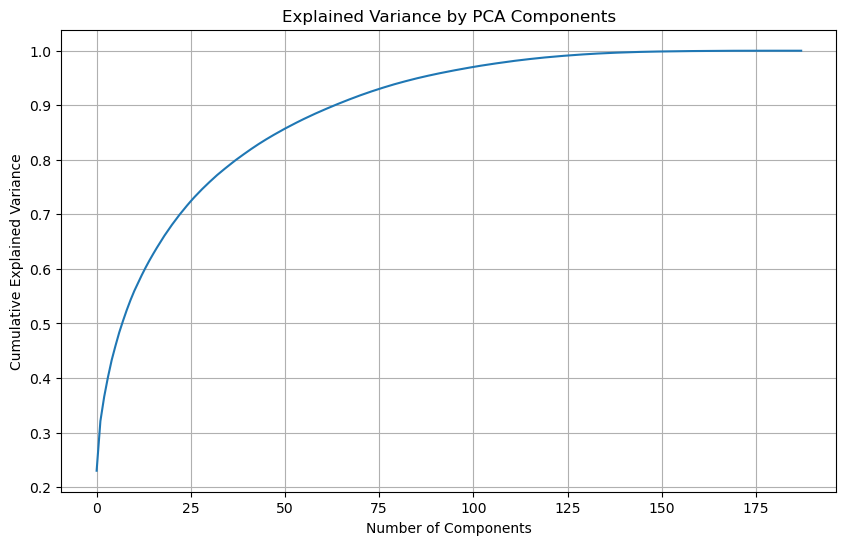

 --- COMPONENT 1 --- 
EBITDA                       0.139259
Gross Profit                 0.138403
Total assets                 0.137232
EBIT                         0.136473
Total current liabilities    0.135603
Total current assets         0.135044
Operating Income             0.133900
Tangible Asset Value         0.133258
Total shareholders equity    0.133236
Revenue                      0.133203
dtype: float64
 --- COMPONENT 2 --- 
netProfitMargin                0.188109
ebitperRevenue                 0.186035
eBITperRevenue                 0.186035
Profit Margin                  0.185705
pretaxProfitMargin             0.184744
EBITDA Margin                  0.179100
Earnings Before Tax Margin     0.170428
EBIT Margin                    0.170342
Net Profit Margin              0.169559
operatingCashFlowSalesRatio    0.159357
dtype: float64
 --- COMPONENT 3 --- 
Tangible Book Value per Share    0.221325
Graham Net-Net                   0.213052
assetTurnover                    0.19493

In [4]:
# 2014 dataset
pca_model_2014, ev_plot_2014, loadings_2014 = perform_pca_analysis(data_2014)
ev_plot_2014.show()

# Displaying loadings
print(' --- COMPONENT 1 --- ')
print(loadings_2014["Component 1"])
print(' --- COMPONENT 2 --- ')
print(loadings_2014["Component 2"])
print(' --- COMPONENT 3 --- ')
print(loadings_2014["Component 3"])

### Overall Summary 2014:

- **Component 1** focuses on **company size and operational performance**, indicating larger, asset-heavy companies with strong revenue-generating capacity.

- **Component 2** emphasizes **profitability efficiency**, representing companies that are particularly good at converting revenue into profits.

- **Component 3** reflects **asset utilization and financial leverage**, identifying companies that make effective use of their assets and have a particular financial structure (leverage, investments).

In summary, these components are well-separated into meaningful financial areas: **size and operations**, **profitability**, and **asset efficiency**. This makes **PCA** a useful dimensionality reduction tool in understanding different financial dynamics within a dataset, helping identify which companies are strong performers in each aspect.

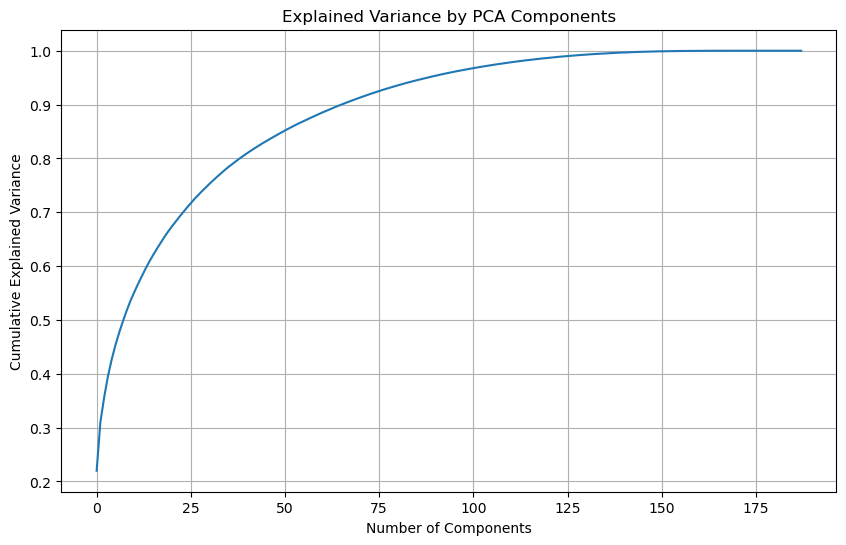

 --- COMPONENT 1 --- 
EBITDA                  0.138591
Total assets            0.137314
Gross Profit            0.137247
Total current assets    0.134978
Enterprise Value        0.134848
Total liabilities       0.134209
Market Cap              0.133711
Revenue                 0.133499
Tangible Asset Value    0.132812
Operating Cash Flow     0.132557
dtype: float64
 --- COMPONENT 2 --- 
netProfitMargin                0.184735
eBITperRevenue                 0.184572
ebitperRevenue                 0.184572
pretaxProfitMargin             0.181426
Profit Margin                  0.181119
EBITDA Margin                  0.175880
EBIT Margin                    0.170944
Earnings Before Tax Margin     0.169335
Net Profit Margin              0.168403
operatingCashFlowSalesRatio    0.146969
dtype: float64
 --- COMPONENT 3 --- 
Net Cash/Marketcap     0.172089
priceBookValueRatio    0.156390
PB ratio               0.156390
EPS Growth             0.151197
EPS Diluted Growth     0.149345
Debt to Assets

In [5]:
# 2015 dataset
pca_model_2015, ev_plot_2015, loadings_2015 = perform_pca_analysis(data_2015)
ev_plot_2015.show()

# Displaying loadings
print(' --- COMPONENT 1 --- ')
print(loadings_2015["Component 1"])
print(' --- COMPONENT 2 --- ')
print(loadings_2015["Component 2"])
print(' --- COMPONENT 3 --- ')
print(loadings_2015["Component 3"])

### Overall Summary (2015):

- **Component 1** focuses on **company size and operational performance**, with high loadings on **EBITDA**, **Total Assets**, **Gross Profit**, and **Enterprise Value**. This suggests the component captures larger companies with strong operational performance and asset-heavy structures.

- **Component 2** emphasizes **profitability efficiency**, as seen in metrics like **Net Profit Margin**, **EBITDA Margin**, and **EBIT Margin**. Companies scoring high on this component are efficient at converting revenue into profits, indicating strong profitability ratios.

- **Component 3** reflects **financial ratios and growth metrics**, focusing on **Net Cash to Market Cap**, **Price-to-Book ratios**, and **EPS Growth**. Companies with higher scores here are characterized by better liquidity, higher book value relative to their market value, and strong earnings growth.

In summary, the 2015 PCA results show meaningful separation into three financial areas: **size and operational performance**, **profitability efficiency**, and **financial ratios/growth metrics**. This provides valuable insight into the different financial dynamics of the dataset, helping to identify which companies excel in each area.


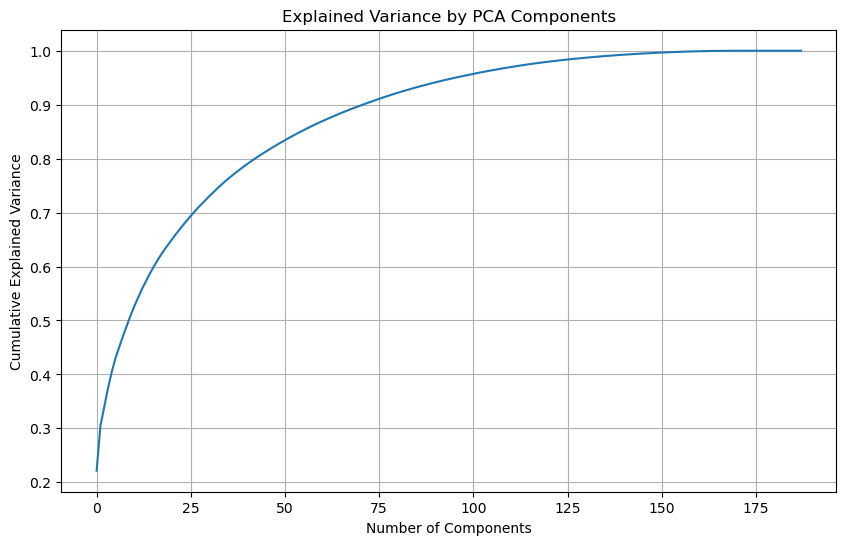

 --- COMPONENT 1 --- 
EBITDA                  0.137985
Total assets            0.135790
Tangible Asset Value    0.134097
Total liabilities       0.133396
Total debt              0.131703
Total current assets    0.131653
EBIT                    0.131518
Gross Profit            0.131014
Invested Capital        0.130524
Market Cap              0.130508
dtype: float64
 --- COMPONENT 2 --- 
netProfitMargin                0.205226
ebitperRevenue                 0.204282
eBITperRevenue                 0.204282
pretaxProfitMargin             0.197964
Profit Margin                  0.192607
EBITDA Margin                  0.188205
Net Profit Margin              0.177934
operatingCashFlowSalesRatio    0.158708
Earnings Before Tax Margin     0.149144
Free Cash Flow margin          0.148565
dtype: float64
 --- COMPONENT 3 --- 
Graham Net-Net                   0.229215
Tangible Book Value per Share    0.224279
assetTurnover                    0.218652
grossProfitMargin                0.215007
Gross 

In [6]:
# 2016 dataset
pca_model_2016, ev_plot_2016, loadings_2016 = perform_pca_analysis(data_2016)
ev_plot_2016.show()

# Displaying loadings
print(' --- COMPONENT 1 --- ')
print(loadings_2016["Component 1"])
print(' --- COMPONENT 2 --- ')
print(loadings_2016["Component 2"])
print(' --- COMPONENT 3 --- ')
print(loadings_2016["Component 3"])

### Overall Summary (2016):

- **Component 1** focuses on **company size and asset performance**, with high loadings on **EBITDA**, **Total Assets**, **Tangible Asset Value**, and **Total Liabilities**. This component captures larger companies with a strong balance sheet, indicating asset-heavy and operationally significant firms.

- **Component 2** emphasizes **profitability margins**, with high contributions from **Net Profit Margin**, **EBITDA Margin**, **EBIT per Revenue**, and **Free Cash Flow Margin**. Companies scoring high on this component are efficient at turning revenues into profits, highlighting their strong operational efficiency and financial performance.

- **Component 3** reflects **asset utilization and financial structure**, with high loadings on **Graham Net-Net**, **Tangible Book Value per Share**, and **Asset Turnover**. Companies with high scores in this component demonstrate effective asset use, strong profitability from assets, and solid equity values.

In summary, the 2016 PCA results divide the dataset into three meaningful financial areas: **company size and asset performance**, **profitability margins**, and **asset utilization and financial structure**. These components provide valuable insights into the financial dynamics of the companies, highlighting strong performers in each domain.


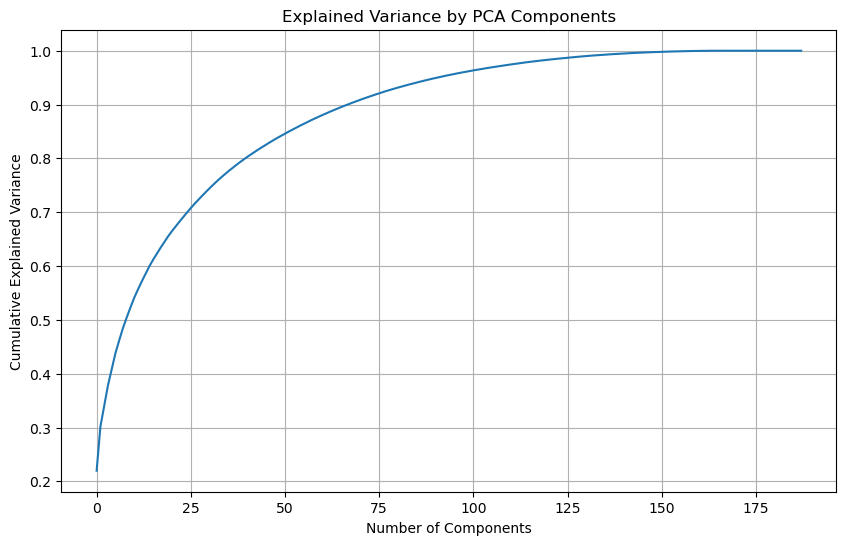

 --- COMPONENT 1 --- 
EBITDA                  0.137498
Total assets            0.131580
Gross Profit            0.131441
Enterprise Value        0.131293
Operating Income        0.131289
Tangible Asset Value    0.130940
EBIT                    0.130825
Total current assets    0.130101
Total liabilities       0.128742
Market Cap              0.127112
dtype: float64
 --- COMPONENT 2 --- 
Profit Margin                  0.186559
netProfitMargin                0.182338
EBITDA Margin                  0.182061
eBITperRevenue                 0.181062
ebitperRevenue                 0.181062
pretaxProfitMargin             0.175212
Net Profit Margin              0.170277
operatingCashFlowSalesRatio    0.161136
EBIT Margin                    0.159905
Earnings Before Tax Margin     0.157621
dtype: float64
 --- COMPONENT 3 --- 
PB ratio                         0.205423
priceBookValueRatio              0.205423
Graham Net-Net                   0.204387
PTB ratio                        0.177993
priceT

In [7]:
# 2017 dataset
pca_model_2017, ev_plot_2017, loadings_2017 = perform_pca_analysis(data_2017)
ev_plot_2017.show()

# Displaying loadings
print(' --- COMPONENT 1 --- ')
print(loadings_2017["Component 1"])
print(' --- COMPONENT 2 --- ')
print(loadings_2017["Component 2"])
print(' --- COMPONENT 3 --- ')
print(loadings_2017["Component 3"])

### Overall Summary (2017):

- **Component 1** focuses on **company size and operational performance**, with high contributions from **EBITDA**, **Total Assets**, **Gross Profit**, and **Enterprise Value**. This component represents companies with strong operational metrics and substantial asset bases, highlighting larger, well-established firms.

- **Component 2** emphasizes **profitability margins**, with high loadings on **Profit Margin**, **Net Profit Margin**, **EBITDA Margin**, and **EBIT per Revenue**. Companies scoring high on this component efficiently generate profits relative to revenue, showcasing strong profitability across various margin metrics.

- **Component 3** reflects **valuation ratios and financial leverage**, dominated by **Price-to-Book (PB) ratios**, **Graham Net-Net**, and **Price to Fair Value**. Companies scoring high here are likely to be valued based on their book value and exhibit a solid asset base relative to market capitalization, providing insights into market valuation and leverage.

In summary, the 2017 PCA results separate the data into three key financial dimensions: **company size and operational performance**, **profitability margins**, and **valuation ratios/financial leverage**. These components allow for a detailed understanding of the financial positioning of companies, highlighting the strengths of each in different financial domains.


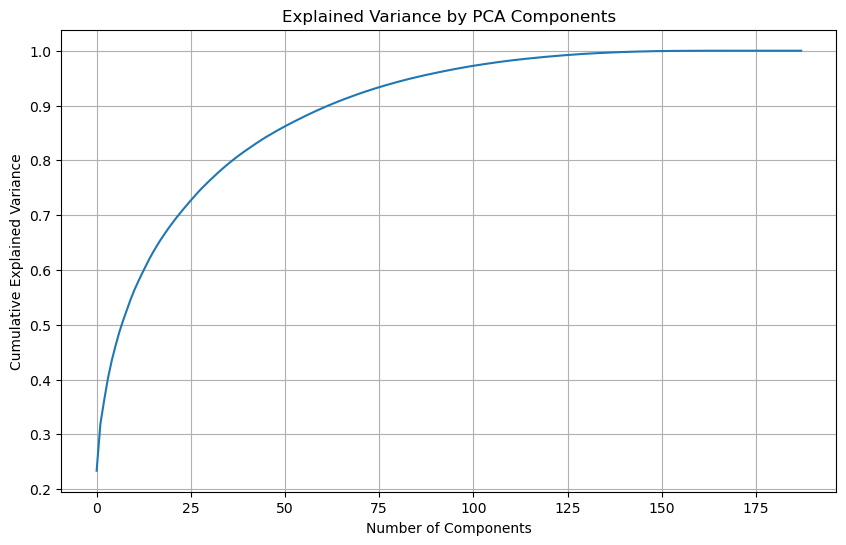

 --- COMPONENT 1 --- 
EBITDA                  0.137816
Total assets            0.135281
EBIT                    0.135135
Total liabilities       0.131277
Tangible Asset Value    0.130758
Gross Profit            0.130670
Market Cap              0.130311
Total current assets    0.129988
Enterprise Value        0.129767
Consolidated Income     0.129159
dtype: float64
 --- COMPONENT 2 --- 
netProfitMargin                0.191992
Profit Margin                  0.191303
ebitperRevenue                 0.190498
eBITperRevenue                 0.190498
pretaxProfitMargin             0.188184
EBITDA Margin                  0.186713
Net Profit Margin              0.178441
EBIT Margin                    0.177797
Earnings Before Tax Margin     0.174745
operatingCashFlowSalesRatio    0.161480
dtype: float64
 --- COMPONENT 3 --- 
PB ratio                     0.198731
priceBookValueRatio          0.198731
Graham Net-Net               0.182537
priceToBookRatio             0.175357
PTB ratio             

In [8]:
# 2018 dataset
pca_model_2018, ev_plot_2018, loadings_2018 = perform_pca_analysis(data_2018)
ev_plot_2018.show()

# Displaying loadings
print(' --- COMPONENT 1 --- ')
print(loadings_2018["Component 1"])
print(' --- COMPONENT 2 --- ')
print(loadings_2018["Component 2"])
print(' --- COMPONENT 3 --- ')
print(loadings_2018["Component 3"])

### Overall Summary (2018):

- **Component 1** focuses on **company size and operational performance**, with high loadings on **EBITDA**, **Gross Profit**, **Total Assets**, and **EBIT**. This component highlights companies with strong operational performance and substantial asset bases, indicating larger and more asset-intensive firms.

- **Component 2** emphasizes **profitability margins**, with strong contributions from **Net Profit Margin**, **EBIT per Revenue**, **EBITDA Margin**, and **Pretax Profit Margin**. Companies scoring highly in this component are those efficiently converting revenue into profits, showcasing operational efficiency and profitability.

- **Component 3** reflects **asset utilization and financial structure**, dominated by **Tangible Book Value per Share**, **Graham Net-Net**, **Asset Turnover**, and **Deposit Liabilities**. This component captures companies with efficient asset usage and strong balance sheet metrics, as well as those with significant financial leverage or investments.

In summary, the 2018 PCA results divide the data into three meaningful areas: **company size and operational performance**, **profitability margins**, and **asset utilization/financial structure**. These components provide a clear picture of companies' financial health and operational efficiency, helping identify strengths in each financial area.



## 2. Clustering

In this step, we will apply **Clustering** techniques to group stocks with similar characteristics. Clustering is an unsupervised learning method that helps identify patterns and relationships in the data by grouping similar data points together. These clusters can be used to create new features that capture the behavior of similar stocks, providing additional insights for the machine learning model.


In [9]:
# Make clustering
def kmeans_clustering_analysis(data, pca_components=2, num_clusters=4):
    """
    Perform K-means clustering on the provided dataset and visualize the clusters.
    
    Parameters:
    - data (DataFrame): The dataset to perform clustering on.
    - pca_components (int): Number of PCA components to use for clustering.
    - num_clusters (int): Number of clusters to form.
    
    Returns:
    - clusters: The cluster labels for each data point.
    - cluster_plot: Matplotlib figure object for the cluster plot.
    """
    # Isolate numeric data for clustering
    numeric_data = data.select_dtypes(include=[np.number])
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_data)
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=pca_components)
    pca_data = pca.fit_transform(scaled_data)
    
    # Determine the optimal number of clusters using the elbow method
    wcss = []
    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(pca_data)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 15), wcss, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method to Determine Optimal Number of Clusters')
    plt.grid(True)
    plt.show()

    # Apply K-means clustering with the chosen number of clusters
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clusters = kmeans.fit_predict(pca_data)

    # Calculate silhouette scores
    silhouette_avg = silhouette_score(pca_data, clusters)
    silhouette_values = silhouette_samples(pca_data, clusters)
    
    # Add cluster labels to the original data
    data['Cluster'] = clusters
    
    # Visualize the clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('K-means Clustering')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    cluster_plot = plt
    
    return clusters, cluster_plot, silhouette_avg, silhouette_values

# Run silhouette
def plot_silhouette_scores(clusters, silhouette_values, num_clusters, silhouette_avg):
    """
    Plot silhouette scores for each sample in each cluster.
    
    Parameters:
    - clusters: Cluster labels for each data point.
    - silhouette_values: Silhouette values for each data point.
    - num_clusters: Number of clusters.
    - silhouette_avg: Average silhouette score.
    
    Returns:
    - silhouette_plot: Matplotlib figure object for the silhouette plot.
    """
    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in range(num_clusters):
        ith_cluster_silhouette_values = silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values)
        
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10

    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.title("Silhouette plot for the various clusters")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

### 2014

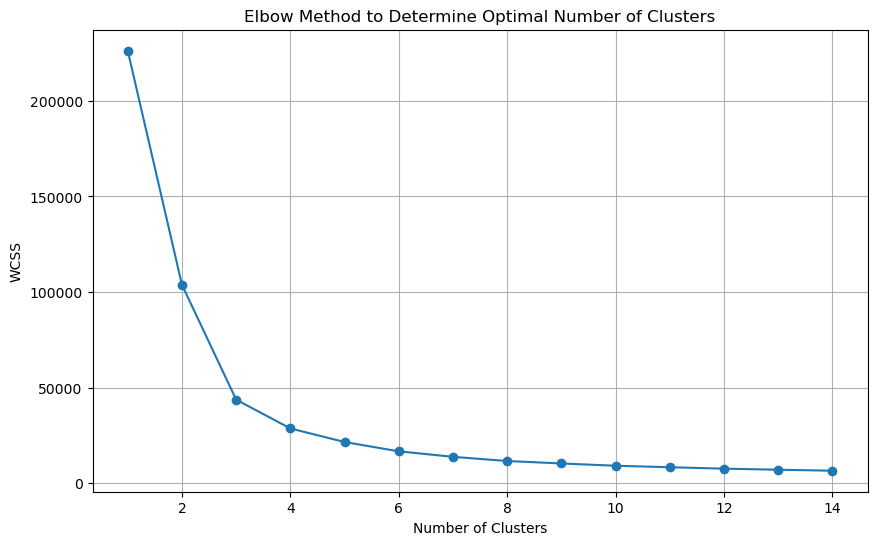

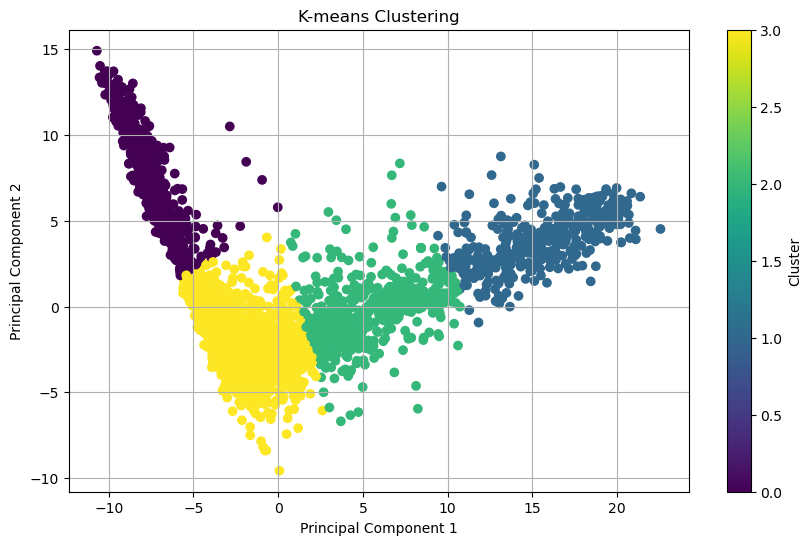

Average Silhouette Score: 0.5757699611474576


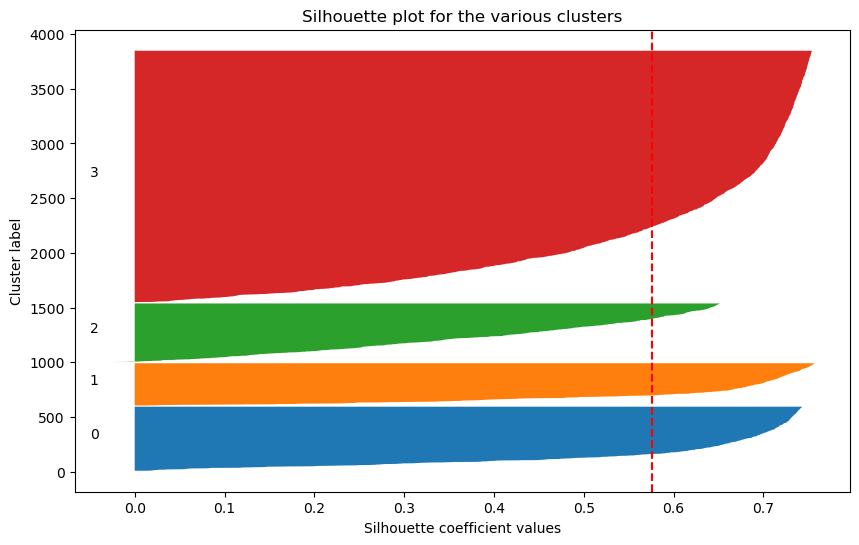

,Symbol,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE VAR [%],Class,Year,Cluster
0,PG,1.664037e+10,-0.071300,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,2.049441e+09,3.144514e+08,...,0.03590,0.031600,0.12280,0.000000,-0.1746,Consumer Defensive,-9.323276,0.0,2014.0,1
1,VIPS,3.734148e+09,1.148175,2.805625e+09,9.285226e+08,100397250.0,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,0.09574,-0.010313,0.27166,0.581968,1.3078,Consumer Defensive,-25.512193,0.0,2014.0,2
2,KR,1.664037e+10,0.018200,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,2.049441e+09,3.144514e+08,...,0.18860,0.326800,0.27380,0.000000,0.0234,Consumer Defensive,33.118297,1.0,2014.0,1
3,RAD,1.664037e+10,0.005300,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,7.372520e+08,3.144514e+08,...,-0.01890,0.196300,-0.04580,0.000000,-0.0060,Consumer Defensive,2.752291,1.0,2014.0,2
4,GIS,1.664037e+10,0.007600,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.412400e+09,2.049441e+09,3.024000e+08,...,0.02150,0.027400,0.10250,0.000000,-0.0220,Consumer Defensive,12.897715,1.0,2014.0,1


In [10]:
clusters, cluster_plot, silhouette_avg, silhouette_values = kmeans_clustering_analysis(data_2014, pca_components=2, num_clusters=4)
cluster_plot.show()

# Silhouette Score
print(f"Average Silhouette Score: {silhouette_avg}")
plot_silhouette_scores(clusters, silhouette_values, num_clusters=4, silhouette_avg=silhouette_avg)

# Display the first few rows of the dataframe with cluster labels
data_2014.head()

### 2015

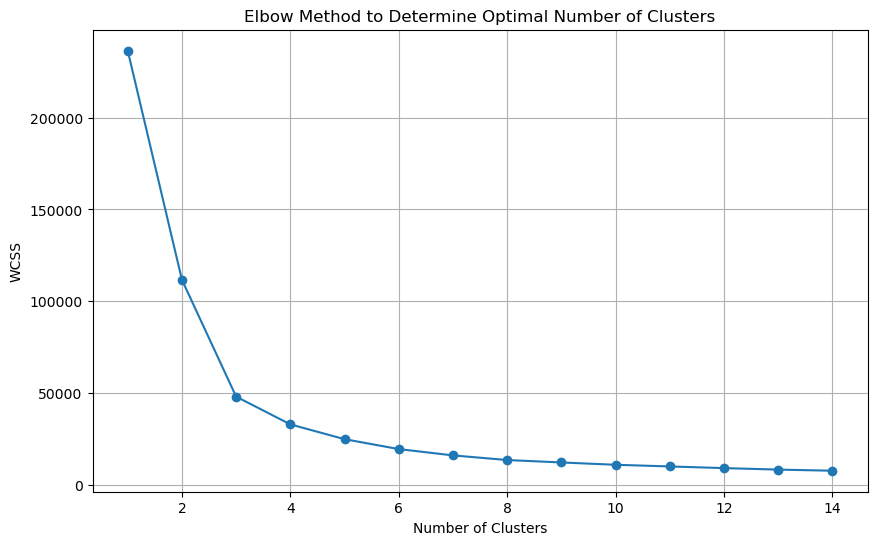

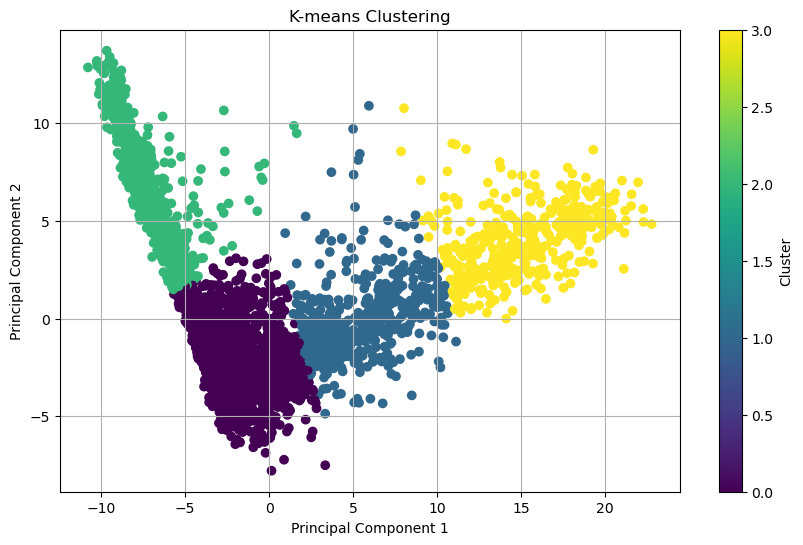

Average Silhouette Score: 0.5647956289579508


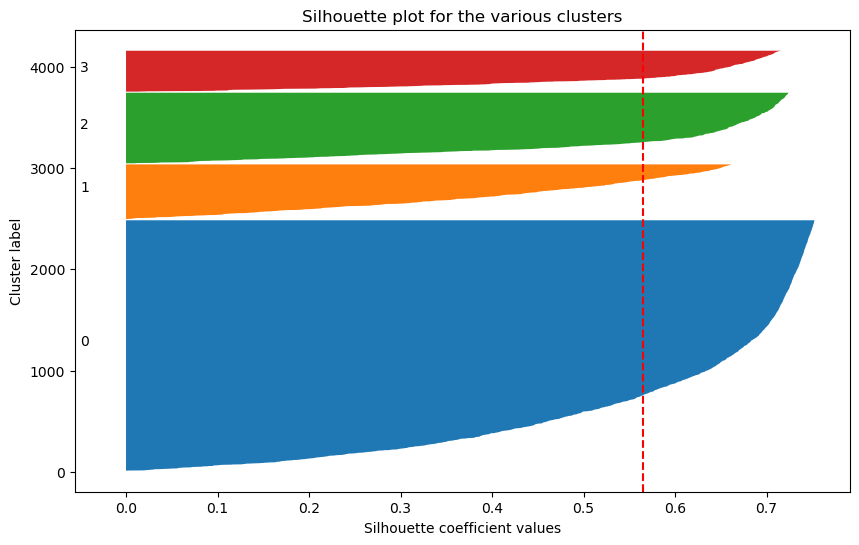

,Symbol,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE VAR [%],Class,Year,Cluster
0,PG,1.533658e+10,-0.0491,8.571762e+09,5.515952e+09,0.0,2.435730e+09,4.231833e+09,1.751761e+09,3.122664e+08,...,-0.1024,-0.1013,-0.1432,0.0000,-0.0394,Consumer Defensive,10.809451,1.0,2015.0,3
1,VIPS,6.193685e+09,0.6587,4.669038e+09,1.524648e+09,120127050.0,5.223879e+08,1.205660e+09,3.189877e+08,1.321245e+07,...,0.1279,0.2946,0.0281,0.4992,0.5179,Consumer Defensive,-21.637010,0.0,2015.0,1
2,KR,1.533658e+10,0.1026,8.571762e+09,5.515952e+09,0.0,2.435730e+09,4.231833e+09,1.751761e+09,3.122664e+08,...,0.0415,0.0535,0.0254,0.0000,0.1293,Consumer Defensive,-15.036503,0.0,2015.0,3
3,RAD,1.533658e+10,0.0393,8.571762e+09,5.515952e+09,0.0,2.435730e+09,4.231833e+09,8.429440e+08,3.122664e+08,...,0.2639,1.0266,-0.0344,0.0000,0.0205,Consumer Defensive,4.303799,1.0,2015.0,1
4,GIS,1.533658e+10,-0.0156,8.571762e+09,5.515952e+09,0.0,2.435730e+09,3.871900e+09,1.751761e+09,3.122664e+08,...,-0.0568,-0.2118,0.0462,0.0000,-0.0421,Consumer Defensive,10.693172,1.0,2015.0,3


In [11]:
clusters, cluster_plot, silhouette_avg, silhouette_values = kmeans_clustering_analysis(data_2015, pca_components=2, num_clusters=4)
cluster_plot.show()

# Silhouette Score
print(f"Average Silhouette Score: {silhouette_avg}")
plot_silhouette_scores(clusters, silhouette_values, num_clusters=4, silhouette_avg=silhouette_avg)

# Display the first few rows of the dataframe with cluster labels
data_2015.head()

### 2016

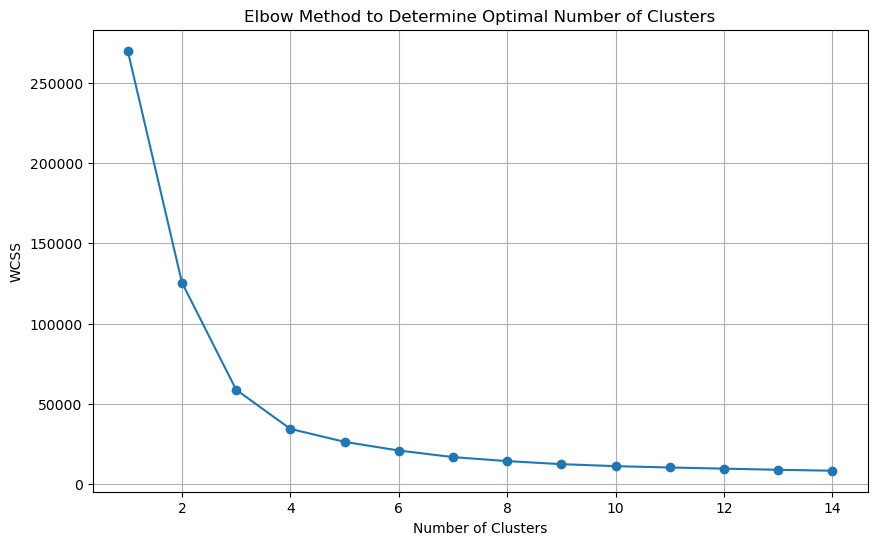

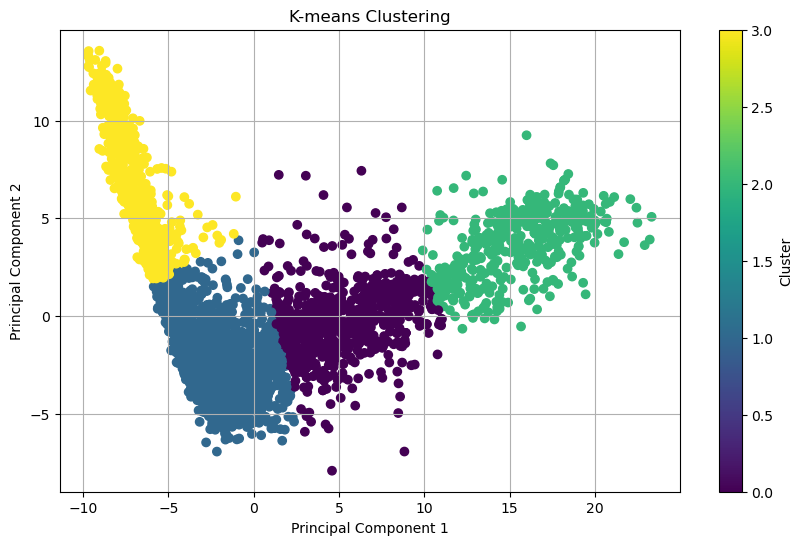

Average Silhouette Score: 0.5892743582358779


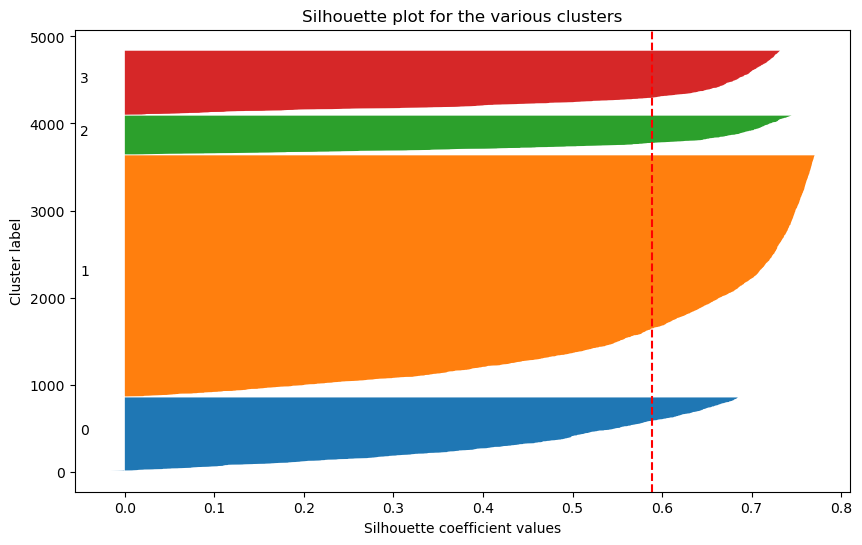

,Symbol,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE VAR [%],Class,Year,Cluster
0,PG,2.658298e+10,-0.0770,1.429203e+10,6.738526e+09,0.000000e+00,3.324155e+09,8.704505e+09,2.662634e+09,4.226952e+08,...,-0.0182,-0.062700,0.0083,0.0000,-0.0809,Consumer Defensive,12.532463,1.0,2016.0,2
1,VIPS,8.148496e+09,0.3156,6.190740e+09,1.957756e+09,1.760878e+08,6.880959e+08,1.567877e+09,3.898789e+08,1.226710e+07,...,0.1706,0.510900,-0.0139,0.3575,0.3172,Consumer Defensive,4.363319,1.0,2016.0,0
2,KR,2.658298e+10,0.0126,1.429203e+10,6.738526e+09,0.000000e+00,3.324155e+09,8.704505e+09,2.662634e+09,4.226952e+08,...,0.1115,0.279700,0.0416,0.0000,0.0457,Consumer Defensive,-17.068252,0.0,2016.0,2
3,RAD,2.077024e+10,-0.2171,1.429203e+10,4.991979e+09,0.000000e+00,3.324155e+09,4.621042e+09,3.709370e+08,1.861320e+08,...,0.2848,1.630333,0.2581,0.0000,-0.3158,Consumer Defensive,-75.916870,0.0,2016.0,0
4,GIS,1.656310e+10,-0.0605,1.073360e+10,5.829500e+09,0.000000e+00,3.118900e+09,3.270300e+09,2.559200e+09,3.038000e+08,...,-0.0055,-0.010500,-0.0828,0.0000,-0.0628,Consumer Defensive,-1.162942,0.0,2016.0,2


In [12]:
clusters, cluster_plot, silhouette_avg, silhouette_values = kmeans_clustering_analysis(data_2016, pca_components=2, num_clusters=4)
cluster_plot.show()

# Silhouette Score
print(f"Average Silhouette Score: {silhouette_avg}")
plot_silhouette_scores(clusters, silhouette_values, num_clusters=4, silhouette_avg=silhouette_avg)

# Display the first few rows of the dataframe with cluster labels
data_2016.head()

### 2017

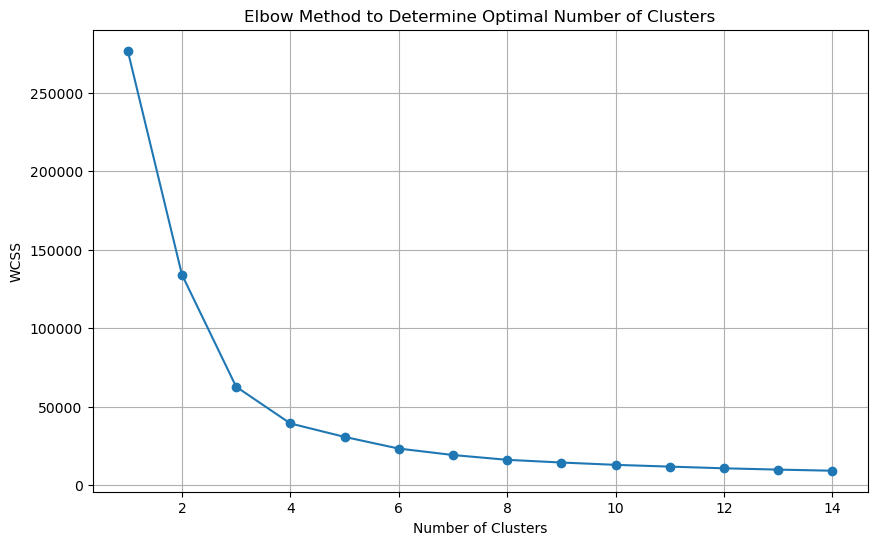

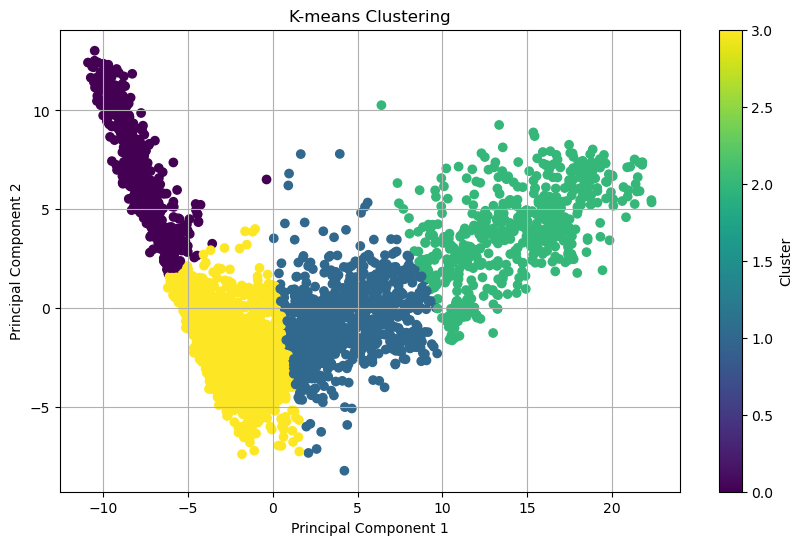

Average Silhouette Score: 0.5277598689145724


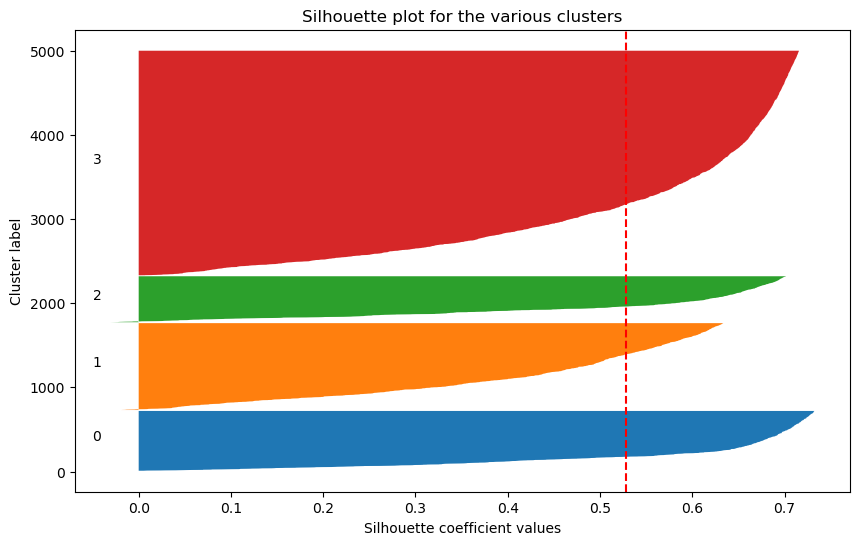

,Symbol,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE VAR [%],Class,Year,Cluster
0,PG,2.858104e+10,-0.0037,9.185210e+09,9.252268e+09,0.0,3.023052e+09,4.125478e+09,2.582559e+09,3.633212e+08,...,-0.0529,0.00120,0.0325,0.0000,-0.0156,Consumer Defensive,4.975151,1.0,2017.0,2
1,VIPS,1.102060e+10,0.3525,8.557810e+09,2.462794e+09,158025300.0,8.201852e+08,2.056136e+09,4.066575e+08,1.245995e+07,...,0.5889,1.43465,0.3805,0.2141,0.1920,Consumer Defensive,-56.320000,0.0,2017.0,1
2,KR,2.858104e+10,0.0501,9.185210e+09,9.252268e+09,0.0,3.023052e+09,4.125478e+09,2.582559e+09,3.633212e+08,...,0.0769,0.00710,0.1654,0.0000,0.0678,Consumer Defensive,-0.990449,0.0,2017.0,2
3,RAD,2.292754e+10,0.1039,9.185210e+09,5.064707e+09,0.0,3.023052e+09,4.125478e+09,2.485830e+08,2.000650e+08,...,0.0281,0.05020,-0.5295,0.0000,0.0427,Consumer Defensive,-66.666666,0.0,2017.0,1
4,GIS,1.561980e+10,-0.0570,9.185210e+09,5.567800e+09,0.0,2.888800e+09,3.069200e+09,2.498600e+09,2.951000e+08,...,0.0046,-0.09430,0.1246,0.0000,-0.0738,Consumer Defensive,-31.280412,0.0,2017.0,2


In [13]:
clusters, cluster_plot, silhouette_avg, silhouette_values = kmeans_clustering_analysis(data_2017, pca_components=2, num_clusters=4)
cluster_plot.show()

# Silhouette Score
print(f"Average Silhouette Score: {silhouette_avg}")
plot_silhouette_scores(clusters, silhouette_values, num_clusters=4, silhouette_avg=silhouette_avg)

# Display the first few rows of the dataframe with cluster labels
data_2017.head()

### 2018

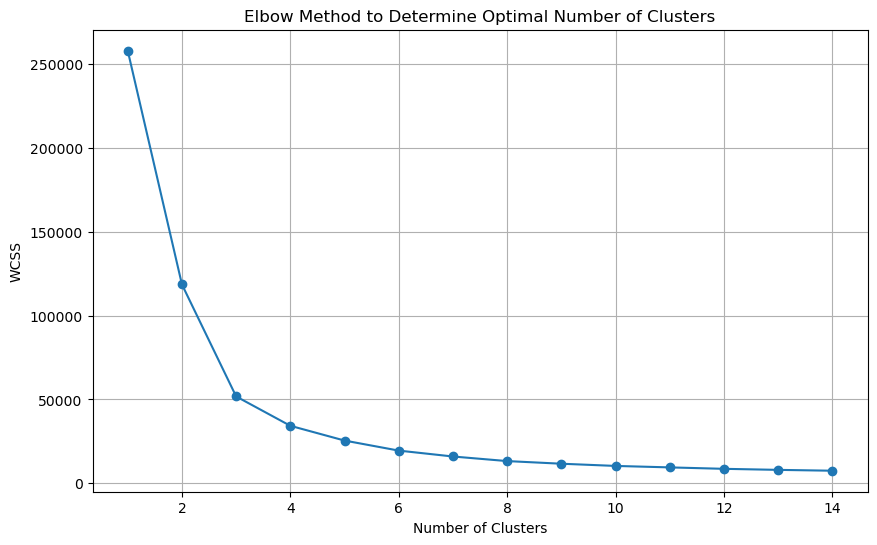

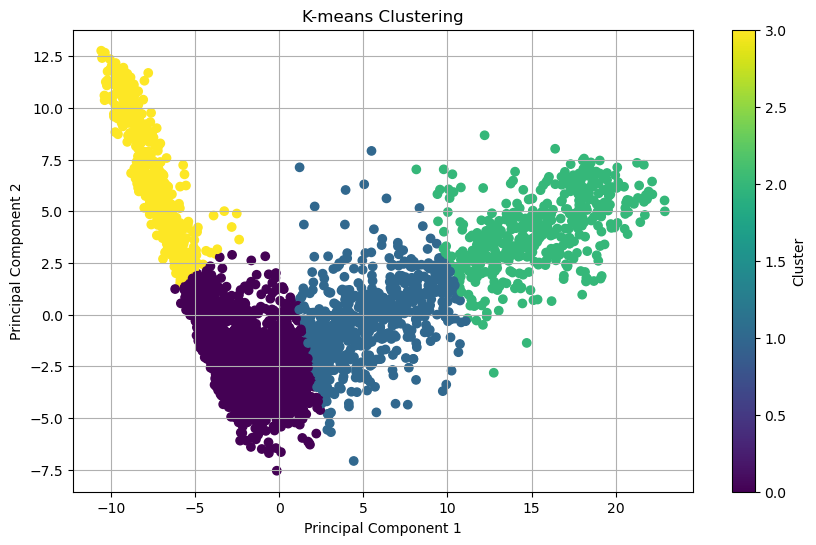

Average Silhouette Score: 0.5565121748675509


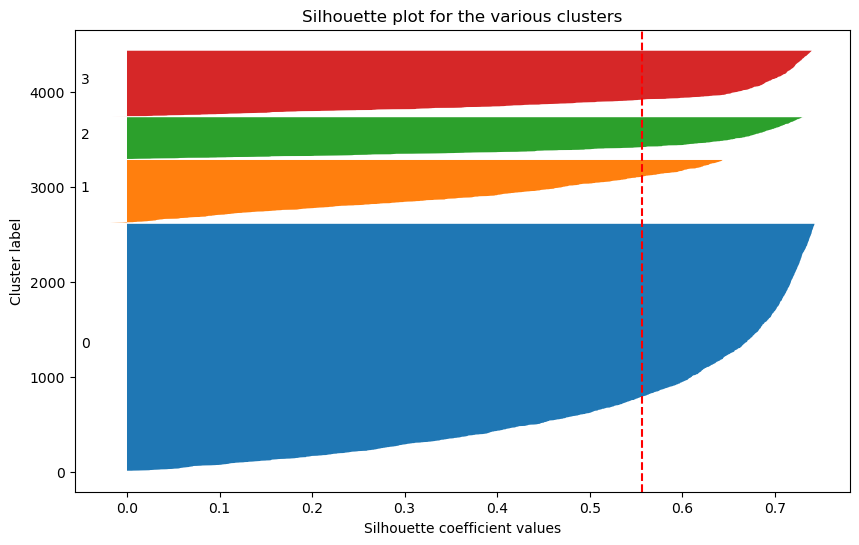

,Symbol,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,PRICE VAR [%],Class,Year,Cluster
0,CMCSA,1.735864e+10,0.1115,0.000000e+00,6.369035e+09,0.0,2.809871e+09,4.531065e+09,2.152973e+09,411913350.0,...,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1.0,2018.0,2
1,KMI,1.414400e+10,0.0320,7.288000e+09,6.369035e+09,0.0,6.010000e+08,3.062000e+09,2.152973e+09,411913350.0,...,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1.0,2018.0,2
2,INTC,1.735864e+10,0.1289,1.004057e+10,6.369035e+09,172435650.0,2.809871e+09,4.531065e+09,2.152973e+09,-126000000.0,...,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1.0,2018.0,2
3,MU,1.735864e+10,0.4955,1.004057e+10,6.369035e+09,172435650.0,8.130000e+08,2.897000e+09,2.152973e+09,342000000.0,...,0.2275,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1.0,2018.0,2
4,GE,1.735864e+10,0.0285,1.004057e+10,6.369035e+09,0.0,2.809871e+09,4.531065e+09,-1.476960e+09,411913350.0,...,-0.1575,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1.0,2018.0,2


In [14]:
clusters, cluster_plot, silhouette_avg, silhouette_values = kmeans_clustering_analysis(data_2018, pca_components=2, num_clusters=4)
cluster_plot.show()

# Silhouette Score
print(f"Average Silhouette Score: {silhouette_avg}")
plot_silhouette_scores(clusters, silhouette_values, num_clusters=4, silhouette_avg=silhouette_avg)

# Display the first few rows of the dataframe with cluster labels
data_2018.head()

### Clustering and Silhouette Analysis (2014-2018)
- **2014**: 
  - Clusters are well-separated based on principal components. The **yellow cluster** likely represents companies with larger size and profitability, while the **purple cluster** could reflect smaller companies or those with lower profitability.
  - Silhouette score around **0.6**, indicating well-defined clusters.

- **2015**: 
  - The clustering shows distinct groupings. The **yellow cluster** on the left suggests companies with stronger operational performance, while the **blue cluster** may represent companies with lower profitability.
  - Silhouette score around **0.6**, indicating reasonable cluster definition.

- **2016**: 
  - The clusters show clear separations across the first two principal components. **Cluster 1 (orange)** contains the most data points, representing companies with shared financial characteristics.
  - Silhouette score around **0.6**, suggesting well-defined but slightly overlapping clusters.

- **2017**: 
  - Clusters are distinct, with the **yellow cluster** likely representing companies with stronger operational performance and the **green cluster** reflecting companies with strong asset bases.
  - Silhouette score around **0.5**, indicating reasonably well-defined clusters with some overlap.

- **2018**: 
  - Clusters are well-separated across the first two principal components. The **yellow cluster** likely represents companies with lower profitability, while the **green cluster** highlights companies with substantial asset bases and profitability.
  - Silhouette score around **0.6**, suggesting well-defined clusters with limited overlap.

### Let's go deeper with the cluster Analisys

In [15]:

# Define the function that processes the dataset for each year
def create_cluster_definition_dataset(df):
    year = int(df['Year'].iloc[0])
    # Add cluster definitions depending on the year
    if year == 2014:
        cluster_definitions = {
            0: 'Low operational performance, low profitability',
            1: 'Medium operational performance, medium profitability',
            2: 'High asset base, high operational performance',
            3: 'High operational efficiency, medium asset base'
        }
    elif year == 2015:
        cluster_definitions = {
            0: 'Medium asset base, medium profitability',
            1: 'Low operational performance, low profitability',
            2: 'High asset base, high operational performance',
            3: 'High operational efficiency, medium asset base'
        }
    elif year == 2016:
        cluster_definitions = {
            0: 'Low operational performance, low profitability',
            1: 'Medium operational performance, medium profitability',
            2: 'High asset base, high operational performance',
            3: 'High operational efficiency, high asset base'
        }
    elif year == 2017:
        cluster_definitions = {
            0: 'Low profitability, low operational performance',
            1: 'Medium operational performance, medium profitability',
            2: 'High operational performance, high profitability',
            3: 'High asset base, medium operational efficiency'
        }
    elif year == 2018:
        cluster_definitions = {
            0: 'Low operational performance, low profitability',
            1: 'Medium operational performance, medium profitability',
            2: 'High operational performance, high profitability',
            3: 'High asset base, high operational efficiency'
        }
    else:
        raise ValueError("Year not defined. Please pass a valid year between 2014 and 2018.")
    
    # Create a new dataset containing the necessary columns
    new_df = df[['Symbol', 'PRICE VAR [%]', 'Class', 'Cluster']].copy()
    
    # Add a new column with the cluster definitions
    new_df['Cluster Definition'] = new_df['Cluster'].map(cluster_definitions)

    # Group by Cluster and create a boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster Definition', y='PRICE VAR [%]', data=new_df)
    
    # Customize the plot
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Price Variation by Cluster Definition for {year}')
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    return new_df

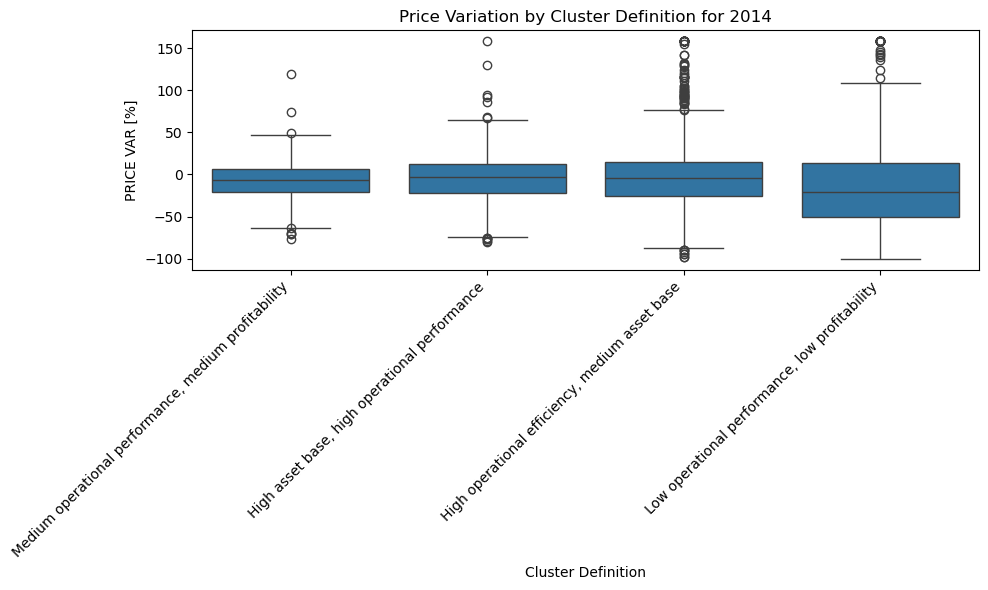

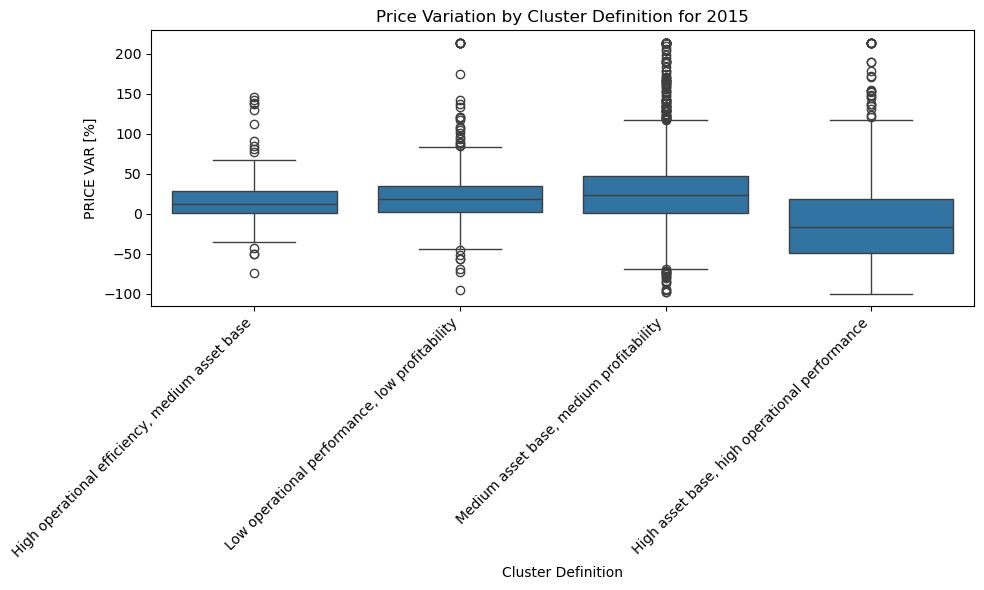

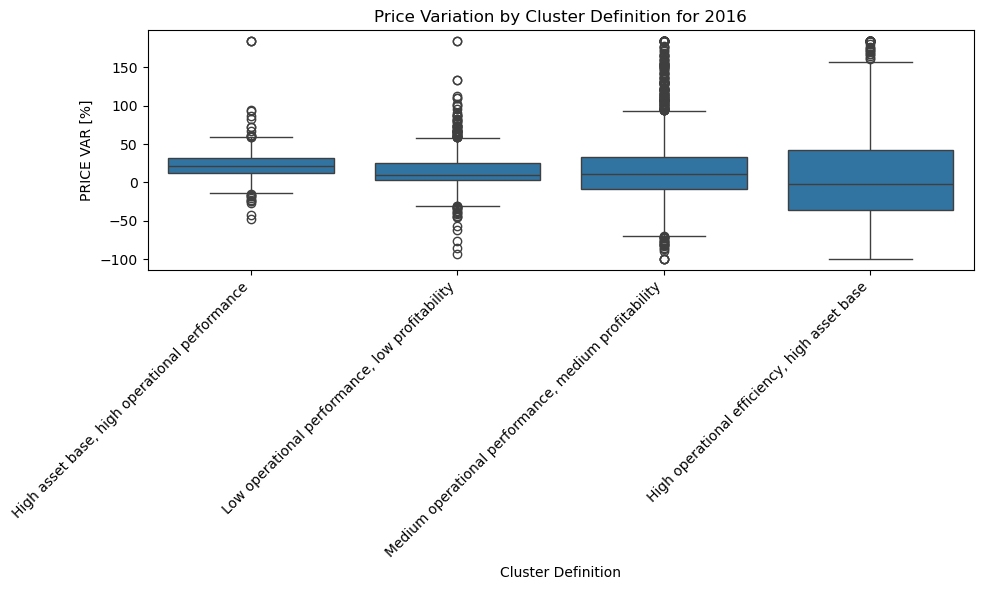

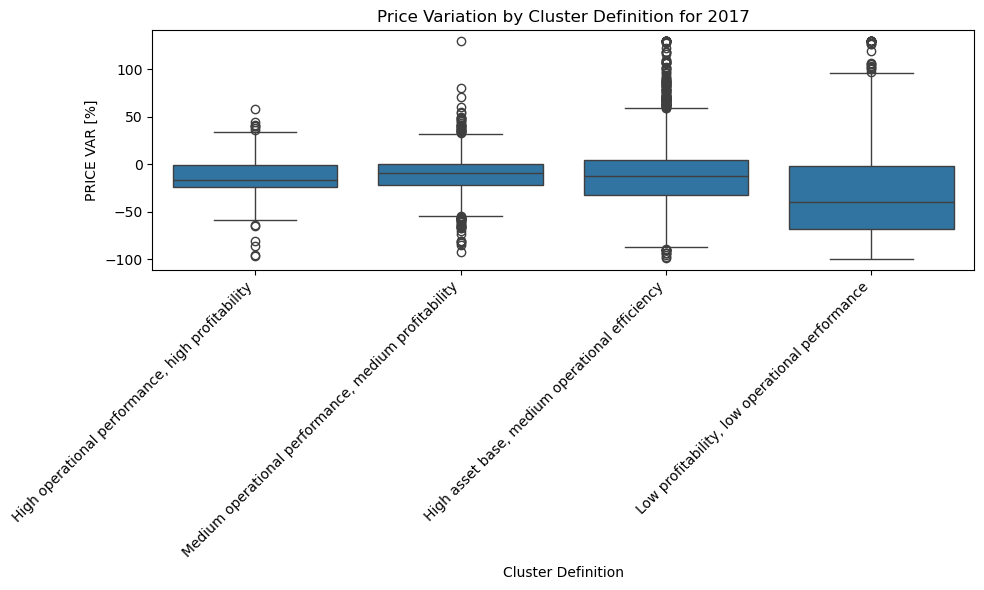

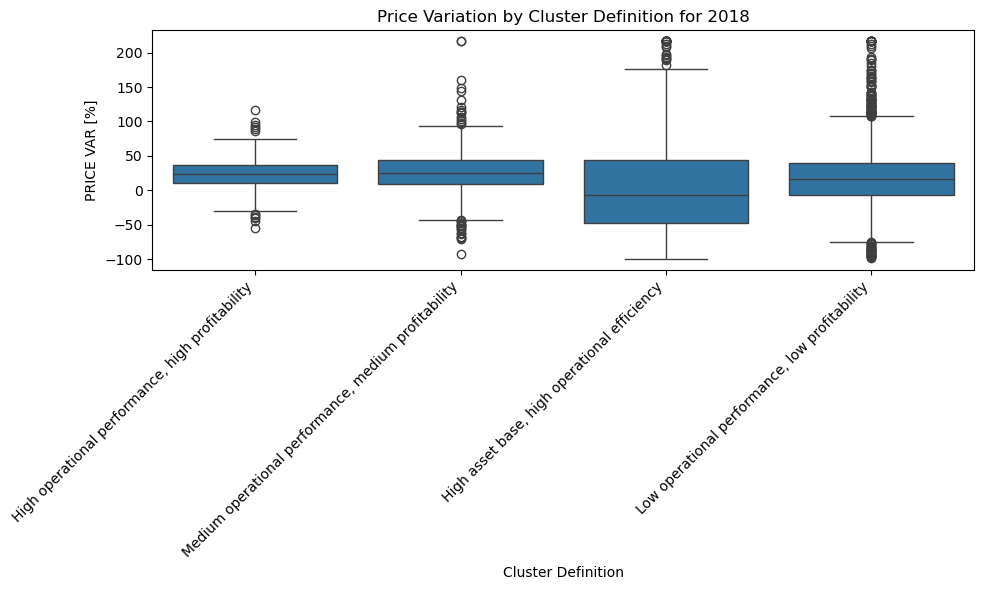

In [16]:
for year, df in full_df.items():
    test = create_cluster_definition_dataset(df)


### Price Variation Analysis and Investment Decisions by Cluster Definition (2014-2018)

#### 2014 Analysis:
- **Cluster 1: Medium operational performance, medium profitability**  
  - **Price Variation**: Fairly narrow distribution with a median near 0%.  
  - **Investment Decision**: These companies are more stable but may not offer high returns. Suitable for conservative portfolios seeking steady performance with minimal risk.
  
- **Cluster 2: High asset base, high operational performance**  
  - **Price Variation**: Wider distribution and higher volatility, with potential for large gains.  
  - **Investment Decision**: Attractive for growth-oriented investors. High operational and asset base companies may experience larger gains but come with higher risk.

- **Cluster 3: High operational efficiency, medium asset base**  
  - **Price Variation**: Tighter distribution with fewer outliers, indicating stable performance.  
  - **Investment Decision**: Ideal for balanced portfolios, offering moderate returns with relatively low volatility.

- **Cluster 0: Low operational performance, low profitability**  
  - **Price Variation**: Broader, negative distribution, with a significant portion experiencing losses.  
  - **Investment Decision**: Avoid for most portfolios, as these companies are underperforming and carry higher risks of losses.

#### 2015 Analysis:
- **Cluster 1: Low operational performance, low profitability**  
  - **Price Variation**: Wide variation, indicating instability and poor performance.  
  - **Investment Decision**: High risk, likely to underperform. Best to avoid unless betting on a turnaround.

- **Cluster 2: Medium asset base, medium profitability**  
  - **Price Variation**: Stable performance, with fewer extreme outliers.  
  - **Investment Decision**: Suitable for balanced portfolios seeking stable, moderate returns.

- **Cluster 3: High asset base, high operational performance**  
  - **Price Variation**: High volatility with potential for large positive price variations.  
  - **Investment Decision**: Suitable for growth portfolios. Potential for high returns, but expect volatility.

- **Cluster 0: High operational efficiency, medium asset base**  
  - **Price Variation**: Controlled range, indicating stability with moderate gains.  
  - **Investment Decision**: Great for balanced or conservative portfolios. Provides reliable, stable returns.

#### 2016 Analysis:
- **Cluster 2: High asset base, high operational performance**  
  - **Price Variation**: High volatility with some large positive outliers.  
  - **Investment Decision**: Growth-focused investors may find this cluster appealing, with high potential for returns but higher risk.

- **Cluster 1: Low operational performance, low profitability**  
  - **Price Variation**: Negative and low price variation, with many underperforming companies.  
  - **Investment Decision**: Avoid for most portfolios. High risk of losses and poor returns.

- **Cluster 3: High operational efficiency, high asset base**  
  - **Price Variation**: Controlled positive distribution with stability.  
  - **Investment Decision**: Suitable for balanced portfolios seeking steady, predictable returns.

- **Cluster 0: Medium operational performance, medium profitability**  
  - **Price Variation**: Stable with fewer extreme values, indicating moderate returns.  
  - **Investment Decision**: A safe choice for conservative or balanced portfolios aiming for moderate growth with low risk.

#### 2017 Analysis:
- **Cluster 2: High operational performance, high profitability**  
  - **Price Variation**: Positive price variation with large gains, high volatility.  
  - **Investment Decision**: Best suited for aggressive growth portfolios. High returns expected, but with increased risk.

- **Cluster 1: Medium operational performance, medium profitability**  
  - **Price Variation**: Stable with moderate returns.  
  - **Investment Decision**: Ideal for balanced portfolios that prioritize steady returns with lower risk.

- **Cluster 3: High asset base, medium operational efficiency**  
  - **Price Variation**: Steadier, controlled price variations with fewer outliers.  
  - **Investment Decision**: Suitable for conservative investors who value stability and modest returns.

- **Cluster 0: Low profitability, low operational performance**  
  - **Price Variation**: Poor performance with negative price variation.  
  - **Investment Decision**: Avoid for most portfolios, as these companies are likely to underperform.

#### 2018 Analysis:
- **Cluster 2: High operational performance, high profitability**  
  - **Price Variation**: High volatility with potential for large positive returns.  
  - **Investment Decision**: Suitable for high-growth portfolios, but be cautious of the inherent risks in volatile markets.

- **Cluster 1: Medium operational performance, medium profitability**  
  - **Price Variation**: Stable price variation, ideal for steady performance.  
  - **Investment Decision**: Good fit for balanced portfolios seeking moderate growth with low volatility.

- **Cluster 3: High asset base, high operational efficiency**  
  - **Price Variation**: Consistent, positive price variation.  
  - **Investment Decision**: Great for long-term, conservative portfolios that prioritize stability over rapid growth.

- **Cluster 0: Low operational performance, low profitability**  
  - **Price Variation**: Negative performance with poor price variation.  
  - **Investment Decision**: Avoid for most investors due to the high risk of underperformance.

---

### Investment Strategy Recommendations:
1. **Growth-Oriented Portfolios**: Invest in clusters with **high operational performance** and **high asset bases** (Clusters 2 and 3 in most years). These companies are more volatile but offer the potential for higher returns.
2. **Balanced Portfolios**: Focus on clusters with **medium operational performance and medium profitability** (Cluster 1 in most years). These provide stable returns with less volatility, suitable for risk-averse investors.
3. **Conservative Portfolios**: Select clusters with **high operational efficiency** and **medium to high asset bases** (Cluster 3 in many cases). These companies tend to offer more stability, making them ideal for long-term, low-risk investments.
4. **Avoid High-Risk Clusters**: Clusters with **low operational performance** and **low profitability** (Cluster 0) generally show negative or underperforming results. They pose higher risks for losses and should be avoided unless taking a contrarian bet on recovery.

---

### Conclusion:
By analyzing the price variations across different cluster definitions, investors can align their strategies with companies that fit their risk appetite and investment goals. Companies with higher operational performance or asset bases tend to offer greater potential returns, though with increased volatility, while lower-performing clusters should generally be avoided in most investment strategies.


## 3. Target Variable Engineering

In this step, we will create a new **target variable** that identifies stocks that outperform the S&P 500 by more than 2%. Target variable engineering is critical in defining the outcome we want to predict and helps align the model’s learning process with our project’s goal of selecting high-performing stocks.

#### Why Target Variable Engineering?

- **Align with the Project Goal**: The ultimate objective of this project is to build a portfolio of stocks that consistently beats the market. By creating a target variable that reflects stocks outperforming the S&P 500 by more than 2%, we focus the model’s learning on identifying those high-value stocks.
- **Simplify the Prediction Task**: By defining a clear target (outperformance of 2% over the S&P 500), we make the prediction task binary (outperform vs. not outperform), which can improve model accuracy and interpretability.
- **Improve Model Focus**: With a well-defined target, the model will be better able to focus on stocks with the highest potential for positive returns, helping us achieve the goal of beating the market.

#### Steps:
1. **Calculate S&P 500 Performance**: We will use historical data to calculate the S&P 500 returns for the same time period as the stocks in the dataset.
2. **Compare Stock Performance to S&P 500**: For each stock, we will compare its annual performance to the S&P 500. If a stock's performance exceeds the S&P 500 by more than 2%, it will be labeled as a **1** (outperform). Otherwise, it will be labeled as **0** (underperform).
3. **Create the Binary Target Variable**: The target variable will be a binary feature, where 1 represents stocks that outperform the S&P 500 by more than 2%, and 0 represents stocks that do not.

By engineering this target variable, we create a clear objective for the model to focus on: selecting stocks with the highest potential to outperform the market by a significant margin.


In [31]:
# Function to get annual returns for the S&P 500 from Yahoo Finance
def get_sp500_returns(start_year, end_year):
    sp500 = yf.Ticker("^GSPC")
    # Fetch data starting from the year before the first year to calculate percentage change correctly
    sp500_data = sp500.history(period="1d", start=f"{start_year-1}-01-01", end=f"{end_year}-12-31")
    
    # Calculate the annual returns for each year
    sp500_annual_returns = sp500_data['Close'].resample('Y').ffill().pct_change() * 100  # Convert to percentage
    sp500_annual_returns.index = sp500_annual_returns.index.year  # Change index to just the year
    
    # Drop the first year (start_year - 1), as we only care about returns starting from the first full year
    sp500_annual_returns = sp500_annual_returns.loc[start_year:]
    
    return sp500_annual_returns

# Fetch S&P 500 annual returns from 2015 to 2019 (starting from 2014 to calculate the percentage change)
sp500_returns = get_sp500_returns(2015, 2019)

# Threshold for outperforming S&P 500 by more than 2%
outperformance_threshold = 2

# New df to merge
all_dfs = []

# Create the target variable for each dataset
for year, df in full_df.items():
    # Calculate the corresponding S&P 500 return (e.g., 2014 data corresponds to 2015 performance)
    next_year = int(year) + 1
    if next_year in sp500_returns.index:
        sp500_return = sp500_returns[next_year]
        
        # Calculate the threshold for outperformance
        target_threshold = sp500_return + outperformance_threshold
        
        # Create the target variable 'Outperform' (1 if stock outperforms by more than 2%, 0 otherwise)
        df['Outperform'] = np.where(df['PRICE VAR [%]'] > target_threshold, 1, 0)
        
         # Convert the 'Sector' column to dummy variables
        if 'Sector' in df.columns:
            sector_dummies = pd.get_dummies(df['Sector'], drop_first=True).astype(int)
            df = pd.concat([df, sector_dummies], axis=1).drop(columns=['Sector'])
        
        # Append the dataframe to the list
        all_dfs.append(df)
    else:
        print(f"S&P 500 return data for {next_year} not available.")

# Merge all datasets into one
merged_df = pd.concat(all_dfs, ignore_index=True)

# Define the output path
output_path = f"data/for_modeling_datasets/full_Financial_Data_for_modeling.csv"

# Save the merged dataset to the specified output path
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Create directory if it doesn't exist
merged_df.to_csv(output_path, index=False)

print(f"Saved merged dataset with target variable and dummy variables to {output_path}")

# Preview the first 50 rows of the merged dataset
merged_df.head(50)

/tmp/ipykernel_4827/1075814919.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  sp500_annual_returns = sp500_data['Close'].resample('Y').ffill().pct_change() * 100  # Convert to percentage


Saved merged dataset with target variable and dummy variables to data/for_modeling_datasets/full_Financial_Data_for_modeling.csv


,Symbol,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
0,PG,1.664037e+10,-0.071300,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,2.049441e+09,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0
1,VIPS,3.734148e+09,1.148175,2.805625e+09,9.285226e+08,100397250.0,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,0,0,1,0,0,0,0,0,0,0
2,KR,1.664037e+10,0.018200,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,2.049441e+09,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0
3,RAD,1.664037e+10,0.005300,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,7.372520e+08,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0
4,GIS,1.664037e+10,0.007600,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.412400e+09,2.049441e+09,3.024000e+08,...,0,0,1,0,0,0,0,0,0,0
5,PM,1.664037e+10,0.001000,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,2.049441e+09,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0
6,KO,1.664037e+10,-0.018300,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,2.049441e+09,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0
7,WMT,1.664037e+10,0.016300,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,2.049441e+09,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0
8,MDLZ,1.664037e+10,-0.029900,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,2.049441e+09,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0
9,MO,1.664037e+10,0.002300,8.829338e+09,6.055261e+09,0.0,2.283773e+09,2.540000e+09,2.049441e+09,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0


In [25]:
sp500_returns.head()

Date
2015    -0.726600
2016     9.535023
2017    19.419966
2018    -6.237260
2019    28.499508
Name: Close, dtype: float64

In [35]:
df_test = pd.read_csv('data/for_modeling_datasets/full_Financial_Data_for_modeling.csv')
df_test.columns.tolist()

['Symbol',
 'Revenue',
 'Revenue Growth',
 'Cost of Revenue',
 'Gross Profit',
 'R&D Expenses',
 'SG&A Expense',
 'Operating Expenses',
 'Operating Income',
 'Interest Expense',
 'Earnings before Tax',
 'Income Tax Expense',
 'Net Income - Non-Controlling int',
 'Net Income - Discontinued ops',
 'Net Income',
 'Preferred Dividends',
 'Net Income Com',
 'EPS',
 'EPS Diluted',
 'Weighted Average Shs Out',
 'Weighted Average Shs Out (Dil)',
 'Dividend per Share',
 'Gross Margin',
 'EBITDA Margin',
 'EBIT Margin',
 'Profit Margin',
 'Free Cash Flow margin',
 'EBITDA',
 'EBIT',
 'Consolidated Income',
 'Earnings Before Tax Margin',
 'Net Profit Margin',
 'Cash and cash equivalents',
 'Short-term investments',
 'Cash and short-term investments',
 'Receivables',
 'Inventories',
 'Total current assets',
 'Property, Plant & Equipment Net',
 'Goodwill and Intangible Assets',
 'Long-term investments',
 'Tax assets',
 'Total assets',
 'Payables',
 'Short-term debt',
 'Total current liabilities',
 

### 4. Next Steps: Modeling Classification

With the data preprocessed, outliers handled, features engineered, and the target variable created, the next step in this project will be to build and evaluate **classification models**. The goal is to predict whether a stock will **outperform** the S&P 500 by more than 2% based on the financial indicators.

We will implement and evaluate several classification models, including:

1. **Logistic Regression**:
   - A simple and interpretable linear model that will serve as a baseline for classification performance.

2. **Random Forest Classifier**:
   - A robust ensemble model that leverages decision trees and provides feature importance, which may be useful for understanding which indicators contribute the most to stock outperformance.

3. **Gradient Boosting Classifier (e.g., XGBoost, LightGBM)**:
   - Advanced boosting models that can handle complex patterns and interactions between features, potentially improving performance.

4. **Support Vector Machines (SVM)**:
   - A powerful model that aims to find the optimal hyperplane separating outperforming stocks from underperforming ones.

5. **K-Nearest Neighbors (KNN)**:
   - A simple yet effective method that classifies stocks based on their similarity to neighboring data points.

6. **Artificial Neural Networks (Sequential ANN)**:
   - A deep learning model that can capture non-linear relationships in the data. We will build a **Sequential ANN** to model complex interactions between financial indicators.

### Key Steps in the Modeling Process:
- **Model Training**: Train each model using the cleaned and engineered dataset.
- **Model Evaluation**: Evaluate the models using standard classification metrics such as **accuracy**, **precision**, **recall**, **F1 score**, and **AUC-ROC**.
- **Model Comparison**: Compare the performance of all models and select the best-performing model for predicting stock outperformance.
